# Building blocks

This notebook wants to gather the building blocks and find a way to assemble them on a surface.

**Import zone**

In [6]:
# Import needed packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.constants as ct

# Import some classes and functions from the 'electrode' package
from electrode import (System, PolygonPixelElectrode, shaped)

# Import function for shims calculations
from shims import calc_shims 

# set numpy precision to 4 decimals
np.set_printoptions(precision=4)

# Python magic needed for matplotlib
%matplotlib inline

In [7]:
def plot_trap_geometry(s, xmin=-3500, xmax=3500, ymin=-3500, ymax=3500):
    fig, ax = plt.subplots(3, 1, figsize=(15, 25))
  
    # Plot trap geometry
    s.plot(ax[0])
  
    # Plot RF and DC voltages
    s.plot_voltages(ax[1], u=s.rfs)
    s.plot_voltages(ax[2], u=s.dcs)
  
    # Compute voltage range
    vmin = np.min([np.min(s.rfs), np.min(s.dcs)])
    vmax = np.max([np.max(s.rfs), np.max(s.dcs)])
  
    # Colormap normalization
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
  
    # Add colorbars for RF and DC voltages
    cb1 = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], shrink=0.9, aspect=35)
    cb1.ax.tick_params(labelsize=10)
    cb1.set_label('Voltage', fontsize=10)
  
    cb2 = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[2], shrink=0.9, aspect=35)
    cb2.ax.tick_params(labelsize=10)
    cb2.set_label('Voltage', fontsize=10)
  
    # Set titles
    ax[0].set_title("Trap Geometry")
    ax[1].set_title("RF Voltages")
    ax[2].set_title("DC Voltages")
  
    # Set plot limits and properties
    for axi in ax.flat:
        axi.set_aspect("equal")
        axi.set_xlim(xmin, xmax)
        axi.set_ylim(ymin, ymax)
        axi.set_xlabel('x (μm)')
        axi.set_ylabel('y (μm)')
  
    plt.tight_layout()
    plt.show()

In [8]:
def stick_systems(system_list, U_RF, positions, rotations=None):
    electrode_counter = 1  # Start renaming electrodes from RF_1
    
    final_electrodes = []
  
    for system in system_list:
      system_name = system.name  
      x_offset, y_offset = positions.get(system_name, (0, 0))
      angle = np.deg2rad(rotations.get(system_name, 0)) if rotations else 0  # Convert degrees to radians
        
      for electrode in system:
        translated_electrode = electrode  # Clone if modification is needed
        
        # Rename electrode
        translated_electrode.name = f"RF{electrode_counter}"
        electrode_counter += 1
        
        if hasattr(translated_electrode, 'paths'):
          # Apply translation & rotation
          translated_electrode.paths = [
            [(
              x_offset + (x * np.cos(angle) - y * np.sin(angle)), 
              y_offset + (x * np.sin(angle) + y * np.cos(angle))
            ) for x, y in path] 
            for path in translated_electrode.paths
          ]
        
        final_electrodes += [(translated_electrode.name, translated_electrode.paths)]

    assembled_system = System([PolygonPixelElectrode(name=n, paths=map(np.array, p)) for n, p in final_electrodes], 'total_s')
    
    for e in assembled_system:
        e.rf = U_RF

    return assembled_system



def find_block_limits(electrode_system):
    block_limits = {}

    # Iterate through the electrodes in the system
    for electrode in electrode_system:
        electrode_name = electrode.name
        all_x, all_y = [], []

        # Check if the electrode has the 'paths' attribute
        if hasattr(electrode, 'paths'):  
            # Iterate over the paths (polygons) of the electrode
            for path in electrode.paths:
                # Extract x and y coordinates from each path
                x_values, y_values = zip(*path)  # Unpack coordinates from the path
                all_x.extend(x_values)
                all_y.extend(y_values)

            # Find the min/max limits of the electrode based on the collected coordinates
            x_min, x_max = min(all_x), max(all_x)
            y_min, y_max = min(all_y), max(all_y)

            # Store the limits for each electrode in the block_limits dictionary
            block_limits[electrode_name] = {
                'x_min': x_min, 'x_max': x_max, 
                'y_min': y_min, 'y_max': y_max
            }

    return block_limits


def find_system_limits(electrode_system):
    system_limits = {
        'x_min': float('inf'), 'x_max': float('-inf'),
        'y_min': float('inf'), 'y_max': float('-inf')
    }

    # Iterate through each electrode in the system
    for electrode in electrode_system:
        # Get the individual limits of the current electrode
        electrode_limits = find_block_limits([electrode])[electrode.name]  # Using the previous function

        # Update the overall system limits
        system_limits['x_min'] = min(system_limits['x_min'], electrode_limits['x_min'])
        system_limits['x_max'] = max(system_limits['x_max'], electrode_limits['x_max'])
        system_limits['y_min'] = min(system_limits['y_min'], electrode_limits['y_min'])
        system_limits['y_max'] = max(system_limits['y_max'], electrode_limits['y_max'])

    return system_limits




def build_junction(C_length, C_width, RF_width, X_control, control_points, U_RF, name):
    X_control_top = np.linspace(-X_control - C_width/2 - RF_width, - C_width/2 - RF_width, len(control_points[0]) + 1)
    X_control_bottom = np.linspace(-X_control - C_width/2 - RF_width, -C_width/2, len(control_points[1]) + 1)
    
    X_top, X_bottom = X_control_top[1:-1], X_control_bottom[1:-1]
    Y_top, Y_bottom = control_points
    
    base_shape = [(-C_length/2, C_width/2),
                  (-X_control - C_width/2 - RF_width, C_width/2)]
    
    # Add other control points dynamically for the top and bottom lines
    for i in range(0, len(X_bottom)):
        base_shape.append((X_bottom[i], Y_bottom[i]))
        
    base_shape.append((-Y_bottom[-1], Y_bottom[-1]))
    
    for i in range(0, len(X_bottom)):
        base_shape.append((-Y_bottom[-i-2], -X_bottom[-i-1]))
        
    base_shape.extend([(-C_width/2, X_control + C_width/2 + RF_width),
                       (-C_width/2, C_length/2),
                       (-C_width/2 - RF_width, C_length/2),
                       (-C_width/2 - RF_width, X_control + C_width/2 + RF_width),])
    
    for i in range(0, len(X_top)):
        base_shape.append((-Y_top[i], -X_top[i]))
                      
    base_shape.append((-Y_top[-1], Y_top[-1]))
    
    for i in range(0, len(X_top)):
        base_shape.append((X_top[-i-1], Y_top[-i-2]))
        
    base_shape.extend([(-X_control - C_width/2 - RF_width, C_width/2 + RF_width),
                       (-C_length/2, C_width/2 + RF_width)])
        
    # Ensure counter-clockwise ordering after mirroring
    RF_electrodes = [
        ("RF1", [base_shape]),  # Original
        ("RF2", [[(x, -y) for x, y in reversed(base_shape)]]),  # Mirrored over x-axis
        ("RF3", [[(-x, y) for x, y in reversed(base_shape)]]),  # Mirrored over y-axis
        ("RF4", [[(-x, -y) for x, y in base_shape]])  # Mirrored over both axes (already CCW)
    ]
    
    electrodes = []
    
    # Add the RF electrodes to the list
    electrodes += RF_electrodes
    
    # Build the system of electrodes
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p)) for n, p in electrodes], name)
    
    s['RF1'].rf = U_RF
    s['RF2'].rf = U_RF
    s['RF3'].rf = U_RF
    s['RF4'].rf = U_RF
        
    return s

def build_linear(C_length, C_width, RF_width, U_RF, name):
    base_shape = [(-C_length/2, C_width/2 + RF_width), 
                  (-C_length/2, C_width/2), 
                  (C_length/2, C_width/2), 
                  (C_length/2, C_width/2 + RF_width)]
    
    RF_electrodes = [("RF1", [base_shape]),
                     ("RF2", [[(x, -y) for x, y in reversed(base_shape)]])]
    
    # Build the system of electrodes
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p)) for n, p in RF_electrodes], name)
    
    s['RF1'].rf = U_RF
    s['RF2'].rf = U_RF
        
    return s

In [9]:
from scipy.interpolate import make_interp_spline

def build_junction_spline(C_length, C_width, RF_width, X_control, control_points, U_RF, name):
    # Define the control points for the top and bottom rails
    X_control_top = np.linspace(-X_control - C_width/2 - RF_width, -C_width/2 - RF_width, len(control_points[0]))
    X_control_bottom = np.linspace(-X_control - C_width/2 - RF_width, -C_width/2, len(control_points[1]))
    
    X_top, X_bottom = X_control_top, X_control_bottom
    Y_top, Y_bottom = control_points

    # Create boundary conditions: (1, 0.0) means first derivative (slope) = 0 at the start
    bc_type = ([(1, 0.0)], [(1, 1.0)]) # First derivative = 0 at the start, no condition at the end

    # Use make_interp_spline for cubic spline interpolation with boundary conditions
    spline_top = make_interp_spline(X_top, Y_top, bc_type=bc_type, k=3)
    spline_bottom = make_interp_spline(X_bottom, Y_bottom, bc_type=bc_type, k=3)

    # Sample interpolated points
    num_samples = 50
    x_new_top = np.linspace(min(X_top), max(X_top), num_samples)
    x_new_bottom = np.linspace(min(X_bottom), max(X_bottom), num_samples)

    # Evaluate the spline at these points
    X_top_spline = x_new_top
    Y_top_spline = spline_top(x_new_top)
    X_bottom_spline = x_new_bottom
    Y_bottom_spline = spline_bottom(x_new_bottom)

    # Now, build the base shape
    base_shape = [(-C_length/2, C_width/2), 
                  (-X_control - C_width/2 - RF_width, C_width/2)]

    # Add the spline points for the top and bottom rails
    for i in range(num_samples):
        base_shape.append((X_bottom_spline[i], Y_bottom_spline[i]))

    base_shape.append((-Y_bottom_spline[-1], Y_bottom_spline[-1]))

    for i in range(num_samples-1):
        base_shape.append((-Y_bottom_spline[-i-1], -X_bottom_spline[-i-1]))

    base_shape.extend([(-C_width/2, X_control + C_width/2 + RF_width),
                       (-C_width/2, C_length/2),
                       (-C_width/2 - RF_width, C_length/2),
                       (-C_width/2 - RF_width, X_control + C_width/2 + RF_width)])

    for i in range(num_samples):
        base_shape.append((-Y_top_spline[i], -X_top_spline[i]))

    base_shape.append((-Y_top_spline[-1], Y_top_spline[-1]))

    for i in range(num_samples-1):
        base_shape.append((X_top_spline[-i-1], Y_top_spline[-i-1]))

    base_shape.extend([(-X_control - C_width/2 - RF_width, C_width/2 + RF_width),
                       (-C_length/2, C_width/2 + RF_width)])

    # Ensure counter-clockwise ordering after mirroring
    RF_electrodes = [
        ("RF_1", [base_shape]),  # Original
        ("RF_2", [[(x, -y) for x, y in reversed(base_shape)]]),  # Mirrored over x-axis
        ("RF_3", [[(-x, y) for x, y in reversed(base_shape)]]),  # Mirrored over y-axis
        ("RF_4", [[(-x, -y) for x, y in base_shape]])  # Mirrored over both axes (already CCW)
    ]

    electrodes = []
    electrodes += RF_electrodes

    # Build the system of electrodes
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p)) for n, p in electrodes], name)

    s['RF_1'].rf = U_RF
    s['RF_2'].rf = U_RF
    s['RF_3'].rf = U_RF
    s['RF_4'].rf = U_RF

    return s

In [10]:
# Wanted trap depth
h = 100

# Dimensions of the central DC electrode (cross-shaped)
C_length = 6000
C_width = 0.83 * h

# Width of the RF electrodes
RF_width = 2 * h

# Dimensions of control points
X_control = 500
top_control = [C_width/2 + RF_width]*1
bottom_control = [C_width/2]*1
control_points = [top_control, bottom_control]

control_points = [[206.8528, 211.7271, 280.4539, 127.3573, 194.7429, 178.379 ],
                  [38.281 , 39.6344, 35.5698, 35.27  , 48.9216, 11.3049]]

In [11]:
L = 1e-6 # μmlength scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)

V_RF = 42 # RF peak voltage
Omega = 2 * np.pi * 20e6 # RF frequency in rad/s

# RF voltage applied to the electrodes parametrized so that the resulting potential equals the RF pseudo-potential in eV
U_RF = V_RF * np.sqrt(Q / M) / (2 * L * Omega)

# Compute factor for normalization
#factor = compute_factor(M, Omega, h, L, Q, V_RF)

In [12]:
s1 = build_junction(C_length, C_width, RF_width, X_control, control_points, U_RF, 's1')
s2 = build_junction(C_length, C_width, RF_width, X_control, control_points, U_RF, 's2')
s3 = build_linear(C_length, C_width, RF_width, U_RF, 's3')
s4 = build_linear(C_length, C_width, RF_width, U_RF, 's4')
s5 = build_linear(C_length, C_width, RF_width, U_RF, 's5')
s6 = build_linear(C_length, C_width, RF_width, U_RF, 's6')
s7 = build_linear(C_length, C_width, RF_width, U_RF, 's7')
s8 = build_linear(C_length, C_width, RF_width, U_RF, 's8')
s9 = build_linear(C_length, C_width, RF_width, U_RF, 's9')
s10 = build_linear(C_length, C_width, RF_width, U_RF, 's10')
s11 = build_linear(C_length, C_width, RF_width, U_RF, 's11')
s12 = build_linear(C_length, C_width, RF_width, U_RF, 's12')
s13 = build_linear(C_length, C_width, RF_width, U_RF, 's13')
systems = [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13]

In [13]:
for s in systems:
    print(f'{s.name} limits = {find_system_limits(s)}')

s1 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -3000.0, 'y_max': 3000.0}
s2 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -3000.0, 'y_max': 3000.0}
s3 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s4 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s5 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s6 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s7 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s8 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s9 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s10 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s11 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s12 limits = {'x_min': -3000.0, 'x_max': 3000.0, 'y_min': -241.5, 'y_max': 241.5}
s13 limits = {'x_min'

In [14]:
# Positions for each system
positions = {
    's1': (-6000, 0), # First junction
    's2': (6000, 0), # Second junction
    's3': (0, 0),
    's4': (-12000, 0),
    's5': (12000, 0),
    's6': (-6000, 6000),
    's7': (-6000, 12000),
    's8': (-6000, -6000),
    's9': (-6000, -12000),
    's10': (6000, 6000),
    's11': (6000, 12000),
    's12': (6000, -6000),
    's13': (6000, -12000),
}

rotations = {
    's1': 0,
    's2': 0,
    's3': 0,
    's4': 0,
    's5': 0,
    's6': 90,
    's7': 90,
    's8': -90,
    's9': -90,
    's10': 90,
    's11': 90,
    's12': -90,
    's13': -90,
}

# Stick the systems together
assembled_system = stick_systems(systems, U_RF, positions, rotations)

In [15]:
def is_counterclockwise(path):
  """Check if a path is counterclockwise using the shoelace theorem."""
  area = 0
  for i in range(len(path)):
    x1, y1 = path[i]
    x2, y2 = path[(i + 1) % len(path)]  # Wrap around to the first point
    area += (x1 * y2 - x2 * y1)
  return area > 0  # CCW if area is positive

for electrode in assembled_system:
  if hasattr(electrode, "paths"):
    for path in electrode.paths:
      ccw = is_counterclockwise(path)
      print(f"Electrode {electrode.name}: {'CCW' if ccw else 'CW'}")


Electrode RF1: CCW
Electrode RF2: CCW
Electrode RF3: CCW
Electrode RF4: CCW
Electrode RF5: CCW
Electrode RF6: CCW
Electrode RF7: CCW
Electrode RF8: CCW
Electrode RF9: CCW
Electrode RF10: CCW
Electrode RF11: CCW
Electrode RF12: CCW
Electrode RF13: CCW
Electrode RF14: CCW
Electrode RF15: CCW
Electrode RF16: CCW
Electrode RF17: CCW
Electrode RF18: CCW
Electrode RF19: CCW
Electrode RF20: CCW
Electrode RF21: CCW
Electrode RF22: CCW
Electrode RF23: CCW
Electrode RF24: CCW
Electrode RF25: CCW
Electrode RF26: CCW
Electrode RF27: CCW
Electrode RF28: CCW
Electrode RF29: CCW
Electrode RF30: CCW


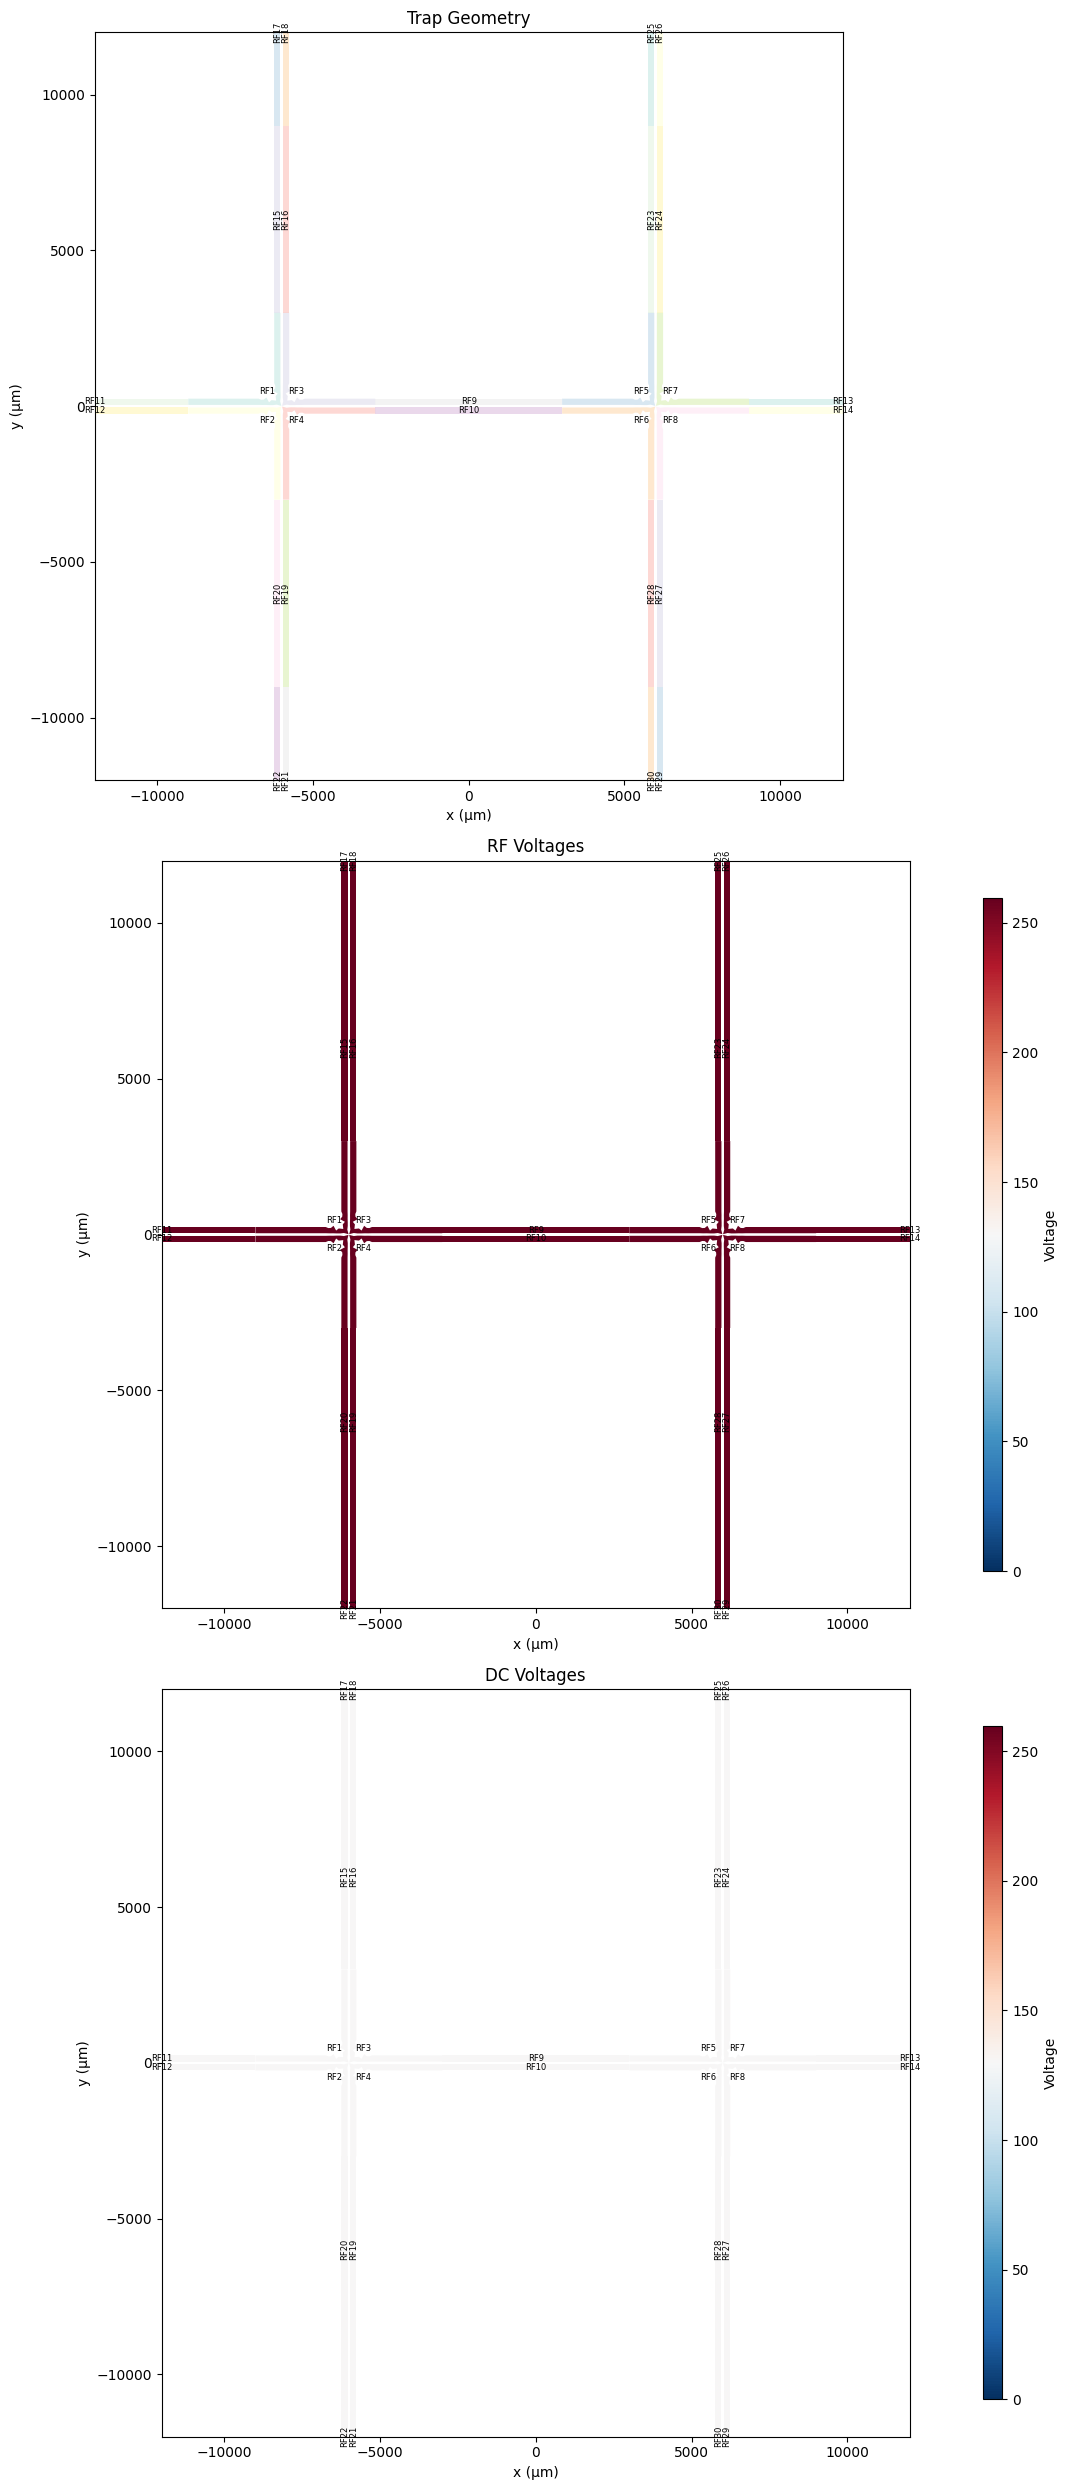

In [17]:
plot_trap_geometry(assembled_system, xmin=-12000, xmax=12000, ymin=-12000, ymax=12000)

In [118]:
# Define subsystems sorted into RF and DC electrodes
s_RF = System([entry for entry in assembled_system if not entry.dc])
s_DC = System([entry for entry in assembled_system if not entry.rf])

# Check which electrode is in which subsystem
print("RF-electrodes: {}".format(s_RF.names))
print("DC-electrodes: {}".format(s_DC.names))

RF-electrodes: ['RF1', 'RF2', 'RF3', 'RF4', 'RF5', 'RF6', 'RF7', 'RF8', 'RF9', 'RF10', 'RF11', 'RF12', 'RF13', 'RF14', 'RF15', 'RF16', 'RF17', 'RF18', 'RF19', 'RF20', 'RF21', 'RF22', 'RF23', 'RF24', 'RF25', 'RF26', 'RF27', 'RF28', 'RF29', 'RF30']
DC-electrodes: []


**Study of the pseudo-potential along x axis**

In [119]:
L = 1e-6 # μmlength scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)

V_RF = 41.4 # RF peak voltage
Omega = 2 * np.pi * 20e6 # RF frequency in rad/s

# RF voltage applied to the electrodes parametrized so that the resulting potential equals the RF pseudo-potential in eV
U_RF = V_RF * np.sqrt(Q / M) / (2 * L * Omega)

# Set all voltages to 0
for electrode in assembled_system:
    electrode.dc = 0
    electrode.rf = 0

# Turn on only RF voltages -> we set them equal to the chosen value of energy
for electrode in s_RF:
    electrode.rf = U_RF
    
print("RF drive frequency: {0:.4g} MHz".format(Omega/(2*np.pi*1e6)))
print("RF voltage: {} V".format(V_RF))
print("Parametrized RF voltage: {} V".format(U_RF))

print("-------------------")

print("DC electrodes and their voltages:")

for e in s_DC:
    print("{}: {}".format(e.name, e.dc))
    
print("-------------------")

print("RF electrodes and their voltages:")

for e in s_RF:
    print("{}: {}".format(e.name, e.rf))
    
print("-------------------")

try:
    x0 = assembled_system.minimum(x0=(-6000., 10., 100.), axis=(1, 2), coord=np.identity(3))
    print(f'Z position of the minimum far from the center = {x0[2]:.3f}')
    x0 = assembled_system.minimum(x0=(-2000., 10., 10.), axis=(1, 2), coord=np.identity(3))
    print(f'Z position of the minimum near the center = {x0[2]:.3f}')
except:
    print("minimum not found")

RF drive frequency: 20 MHz
RF voltage: 41.4 V
Parametrized RF voltage: 255.83569211450026 V
-------------------
DC electrodes and their voltages:
-------------------
RF electrodes and their voltages:
RF1: 255.83569211450026
RF2: 255.83569211450026
RF3: 255.83569211450026
RF4: 255.83569211450026
RF5: 255.83569211450026
RF6: 255.83569211450026
RF7: 255.83569211450026
RF8: 255.83569211450026
RF9: 255.83569211450026
RF10: 255.83569211450026
RF11: 255.83569211450026
RF12: 255.83569211450026
RF13: 255.83569211450026
RF14: 255.83569211450026
RF15: 255.83569211450026
RF16: 255.83569211450026
RF17: 255.83569211450026
RF18: 255.83569211450026
RF19: 255.83569211450026
RF20: 255.83569211450026
RF21: 255.83569211450026
RF22: 255.83569211450026
RF23: 255.83569211450026
RF24: 255.83569211450026
RF25: 255.83569211450026
RF26: 255.83569211450026
RF27: 255.83569211450026
RF28: 255.83569211450026
RF29: 255.83569211450026
RF30: 255.83569211450026
-------------------
Z position of the minimum far from the 

In [120]:
# Compute secular frequencies
try:
    x0 = assembled_system.minimum(x0=(0, x0[1], x0[2]), axis=(0,1,2), coord=np.identity(3))
    curve_z = assembled_system.modes(x0)
    omega_sec = np.sqrt(Q * abs(curve_z[0]) / M) / L
    mode_directions = np.transpose(curve_z[1])
    print("Secular frequencies: ({0:.4g}, {1:.4g}, {2:.4g}) MHz"
          .format(omega_sec[0]/(2*np.pi)/1e6, 
                  omega_sec[1]/(2*np.pi)/1e6, 
                  omega_sec[2]/(2*np.pi)/1e6))
    print("in directions {0[0]}, {0[1]}, {0[2]}".format(mode_directions))
except:
    print("secular frequencies not found")

Secular frequencies: (1.165e-05, 2.825, 2.825) MHz
in directions [1.0000e+00 5.1182e-23 1.1464e-20], [-1.2527e-22  9.9998e-01  6.4624e-03], [-1.1463e-20 -6.4624e-03  9.9998e-01]


In [121]:
max_q = (max(omega_sec))/Omega*np.sqrt(8)
print("max q-parameter {0:.3g}, max q-param per Volt {1:.3g}".format(max_q, max_q/V_RF))
print("--> apply {0:.3g}V for max q=0.4".format(0.4/max_q*V_RF))

max q-parameter 0.4, max q-param per Volt 0.00965
--> apply 41.4V for max q=0.4


In [122]:
x_values = np.linspace(-12000, 12000, 12000)
x0 = (x_values[0], 10., 10.)

pseudopot_values = []
E_values = []
positions = []
omega_sec_values = []

for x in x_values:
    try:
        x0 = assembled_system.minimum(x0=(x, x0[1], x0[2]), axis=(1,2), coord=np.identity(3))
        pseudopot_values.append(assembled_system.potential(x0, 0)[0])
        E_values.append(-assembled_system.potential(x0, 1)[0])
        positions.append(x0)
        curve_z = assembled_system.modes(x0)
        omega_sec_values.append(np.sqrt(Q * abs(curve_z[0]) / M) / L)
    except:
        print("minimum not found")
        pseudopot_values.append(assembled_system.potential(x0, 0)[0])
        positions.append(x0)

opt_params = [pseudopot_values, positions, omega_sec_values]

In [124]:
def plot_ps(x_values, pseudopot_values, positions, omega_sec):
    fig, ax = plt.subplots(4, 1, figsize=(8, 12))  # 4 subplots stacked vertically
  
    # First subplot: Pseudo-potential and its gradient
    ax[0].plot(x_values, np.array(pseudopot_values) / 1e-3, label="Pseudo-potential")
    #gradient_values = np.gradient(np.array(pseudopot_values) / 1e-3, x_values)
    #ax[0].plot(x_values, gradient_values * 10, linestyle='--', label=f'Gradient (magnified * 10) meV/μm\nIntegral = {np.sum(gradient_values):.3f}')
    ax[0].set_ylabel("Pseudo-potential (meV)")
    ax[0].set_title("Pseudo-potential along x")
    ax[0].grid(True, linestyle="--", alpha=0.6)
    ax[0].legend(loc='upper left')
  
    # Second subplot: Position components
#    ax[1].plot(x_values, np.array(positions)[:, 0], label='X Position')
#    ax[1].plot(x_values, np.array(positions)[:, 1], label='Y Position')
    ax[1].plot(x_values, np.array(positions)[:, 2], label='Ion-trap distance')
    ax[1].set_ylabel("Ion-trap distance (μm)")
    ax[1].set_title("Position of the minimum along x")
    ax[1].grid(True, linestyle="--", alpha=0.6)
    ax[1].legend(loc='upper left')
  
    # Third subplot: Axial secular frequency
    omega_sec = np.array(omega_sec)  # Ensure numpy array
    ax[2].plot(x_values, omega_sec[:, 0] / (2 * np.pi) / 1e6, label='Axial frequency', color='C0')
    ax[2].set_ylabel("Secular frequency (MHz)")
    ax[2].set_title("Axial secular frequency along x")
    ax[2].grid(True, linestyle="--", alpha=0.6)
    ax[2].legend(loc='upper left')
  
    # Fourth subplot: Radial secular frequencies
    var_radial_1 = np.var(omega_sec[:, 1] / (2 * np.pi) / 1e6)
    var_radial_2 = np.var(omega_sec[:, 2] / (2 * np.pi) / 1e6)
    ax[3].plot(x_values, omega_sec[:, 1] / (2 * np.pi) / 1e6, label=f'Radial 1 (Var = {var_radial_1:.3f})', color='C1')
    ax[3].plot(x_values, omega_sec[:, 2] / (2 * np.pi) / 1e6, label=f'Radial 2 (Var = {var_radial_2:.3f})', color='C2')
    ax[3].set_ylabel("Secular frequency (MHz)")
    ax[3].set_xlabel("Position along x (μm)")
    ax[3].set_title("Radial secular frequencies along x")
    ax[3].grid(True, linestyle="--", alpha=0.6)
    ax[3].legend(loc='lower left')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

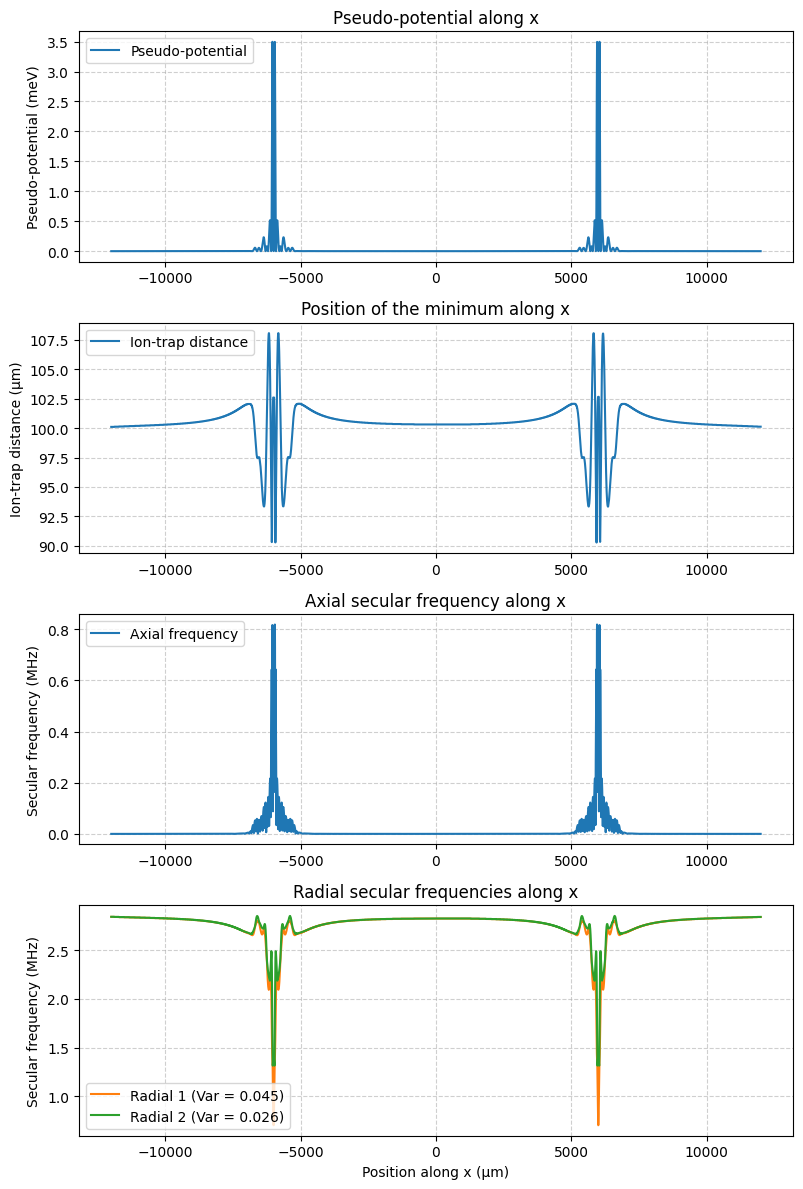

In [125]:
plot_ps(x_values, pseudopot_values, positions, omega_sec_values)

**Joint plot**

In [126]:
def plot_joint_ps(x_values, non_opt_params, opt_params):
    pseudopot_values_1, positions_1, omega_sec_1 = non_opt_params
    pseudopot_values_2, positions_2, omega_sec_2 = opt_params
    fig, ax = plt.subplots(4, 1, figsize=(8, 12))  # 4 subplots stacked vertically
    
    # First subplot: Pseudo-potential and its gradient
    ax[0].plot(x_values, np.array(pseudopot_values_1) / 1e-3, label="Pseudo-potential non opt", linestyle='--')
    ax[0].plot(x_values, np.array(pseudopot_values_2) / 1e-3, label="Pseudo-potential opt")
    ax[0].set_ylabel("Pseudo-potential (meV)")
    ax[0].set_title("Pseudo-potential along x")
    ax[0].grid(True, linestyle="--", alpha=0.6)
    ax[0].legend(loc='upper left')
    
    # Second subplot: Position components
    ax[1].plot(x_values, np.array(positions_1)[:, 2], label='Ion-trap distance non opt', linestyle='--')
    ax[1].plot(x_values, np.array(positions_2)[:, 2], label='Ion-trap distance opt')
    ax[1].set_ylabel("Ion-trap distance (μm)")
    ax[1].set_title("Position of the minimum along x")
    ax[1].grid(True, linestyle="--", alpha=0.6)
    ax[1].legend(loc='upper left')
  
    # Third subplot: Axial secular frequency
    omega_sec_1, omega_sec_2 = np.array(omega_sec_1), np.array(omega_sec_2)  # Ensure numpy array
    ax[2].plot(x_values, omega_sec_1[:, 0] / (2 * np.pi) / 1e6, label='Axial frequency non opt', color='C0', linestyle='--')
    ax[2].plot(x_values, omega_sec_2[:, 0] / (2 * np.pi) / 1e6, label='Axial frequency opt', color='C1')
    ax[2].set_ylabel("Frequency (MHz)")
    ax[2].set_title("Axial secular frequency along x")
    ax[2].grid(True, linestyle="--", alpha=0.6)
    ax[2].legend(loc='upper left')
  
    # Fourth subplot: Radial secular frequencies
    var_radial_1 = np.var(omega_sec_2[:, 1] / (2 * np.pi) / 1e6)
    var_radial_2 = np.var(omega_sec_2[:, 2] / (2 * np.pi) / 1e6)
    ax[3].plot(x_values, omega_sec_1[:, 1] / (2 * np.pi) / 1e6, label=f'Radial 1 non opt', color='C1', linestyle='--')
    ax[3].plot(x_values, omega_sec_1[:, 2] / (2 * np.pi) / 1e6, label=f'Radial 2 non opt', color='C2', linestyle='--')
    ax[3].plot(x_values, omega_sec_2[:, 1] / (2 * np.pi) / 1e6, label=f'Radial 1 (Var = {var_radial_1:.3f})', color='C1')
    ax[3].plot(x_values, omega_sec_2[:, 2] / (2 * np.pi) / 1e6, label=f'Radial 2 (Var = {var_radial_2:.3f})', color='C2')
    ax[3].set_ylabel("Frequency (MHz)")
    ax[3].set_xlabel("Position along x (μm)")
    ax[3].set_title("Radial secular frequencies along x")
    ax[3].grid(True, linestyle="--", alpha=0.6)
    ax[3].legend(loc='lower left')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [127]:
# Wanted trap depth
h = 100

# Dimensions of the central DC electrode (cross-shaped)
C_length = 6000
C_width = 0.83 * h

# Width of the RF electrodes
RF_width = 2 * h

# Dimensions of control points
X_control = 500
top_control = [C_width/2 + RF_width]*1
bottom_control = [C_width/2]*1
control_points = [top_control, bottom_control]

In [128]:
s1 = build_junction(C_length, C_width, RF_width, X_control, control_points, U_RF, 's1')
s2 = build_junction(C_length, C_width, RF_width, X_control, control_points, U_RF, 's2')
s3 = build_linear(C_length, C_width, RF_width, U_RF, 's3')
s4 = build_linear(C_length, C_width, RF_width, U_RF, 's4')
s5 = build_linear(C_length, C_width, RF_width, U_RF, 's5')
s6 = build_linear(C_length, C_width, RF_width, U_RF, 's6')
s7 = build_linear(C_length, C_width, RF_width, U_RF, 's7')
s8 = build_linear(C_length, C_width, RF_width, U_RF, 's8')
s9 = build_linear(C_length, C_width, RF_width, U_RF, 's9')
s10 = build_linear(C_length, C_width, RF_width, U_RF, 's10')
s11 = build_linear(C_length, C_width, RF_width, U_RF, 's11')
s12 = build_linear(C_length, C_width, RF_width, U_RF, 's12')
s13 = build_linear(C_length, C_width, RF_width, U_RF, 's13')
systems = [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13]

In [129]:
# Positions for each system
positions = {
    's1': (-6000, 0), # First junction
    's2': (6000, 0), # Second junction
    's3': (0, 0),
    's4': (-12000, 0),
    's5': (12000, 0),
    's6': (-6000, 6000),
    's7': (-6000, 12000),
    's8': (-6000, -6000),
    's9': (-6000, -12000),
    's10': (6000, 6000),
    's11': (6000, 12000),
    's12': (6000, -6000),
    's13': (6000, -12000),
}

rotations = {
    's1': 0,
    's2': 0,
    's3': 0,
    's4': 0,
    's5': 0,
    's6': 90,
    's7': 90,
    's8': -90,
    's9': -90,
    's10': 90,
    's11': 90,
    's12': -90,
    's13': -90,
}

# Stick the systems together
assembled_system = stick_systems(systems, U_RF, positions, rotations)

In [130]:
# Define subsystems sorted into RF and DC electrodes
s_RF = System([entry for entry in assembled_system if not entry.dc])
s_DC = System([entry for entry in assembled_system if not entry.rf])

# Check which electrode is in which subsystem
print("RF-electrodes: {}".format(s_RF.names))
print("DC-electrodes: {}".format(s_DC.names))

RF-electrodes: ['RF1', 'RF2', 'RF3', 'RF4', 'RF5', 'RF6', 'RF7', 'RF8', 'RF9', 'RF10', 'RF11', 'RF12', 'RF13', 'RF14', 'RF15', 'RF16', 'RF17', 'RF18', 'RF19', 'RF20', 'RF21', 'RF22', 'RF23', 'RF24', 'RF25', 'RF26', 'RF27', 'RF28', 'RF29', 'RF30']
DC-electrodes: []


In [131]:
L = 1e-6 # μmlength scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)

V_RF = 41.4 # RF peak voltage
Omega = 2 * np.pi * 20e6 # RF frequency in rad/s

# RF voltage applied to the electrodes parametrized so that the resulting potential equals the RF pseudo-potential in eV
U_RF = V_RF * np.sqrt(Q / M) / (2 * L * Omega)

# Set all voltages to 0
for electrode in assembled_system:
    electrode.dc = 0
    electrode.rf = 0

# Turn on only RF voltages -> we set them equal to the chosen value of energy
for electrode in s_RF:
    electrode.rf = U_RF
    
print("RF drive frequency: {0:.4g} MHz".format(Omega/(2*np.pi*1e6)))
print("RF voltage: {} V".format(V_RF))
print("Parametrized RF voltage: {} V".format(U_RF))

print("-------------------")

print("DC electrodes and their voltages:")

for e in s_DC:
    print("{}: {}".format(e.name, e.dc))
    
print("-------------------")

print("RF electrodes and their voltages:")

for e in s_RF:
    print("{}: {}".format(e.name, e.rf))
    
print("-------------------")

try:
    x0 = assembled_system.minimum(x0=(-6000., 10., 100.), axis=(1, 2), coord=np.identity(3))
    print(f'Z position of the minimum far from the center = {x0[2]:.3f}')
    x0 = assembled_system.minimum(x0=(-2000., 10., 10.), axis=(1, 2), coord=np.identity(3))
    print(f'Z position of the minimum near the center = {x0[2]:.3f}')
except:
    print("minimum not found")

RF drive frequency: 20 MHz
RF voltage: 41.4 V
Parametrized RF voltage: 255.83569211450026 V
-------------------
DC electrodes and their voltages:
-------------------
RF electrodes and their voltages:
RF1: 255.83569211450026
RF2: 255.83569211450026
RF3: 255.83569211450026
RF4: 255.83569211450026
RF5: 255.83569211450026
RF6: 255.83569211450026
RF7: 255.83569211450026
RF8: 255.83569211450026
RF9: 255.83569211450026
RF10: 255.83569211450026
RF11: 255.83569211450026
RF12: 255.83569211450026
RF13: 255.83569211450026
RF14: 255.83569211450026
RF15: 255.83569211450026
RF16: 255.83569211450026
RF17: 255.83569211450026
RF18: 255.83569211450026
RF19: 255.83569211450026
RF20: 255.83569211450026
RF21: 255.83569211450026
RF22: 255.83569211450026
RF23: 255.83569211450026
RF24: 255.83569211450026
RF25: 255.83569211450026
RF26: 255.83569211450026
RF27: 255.83569211450026
RF28: 255.83569211450026
RF29: 255.83569211450026
RF30: 255.83569211450026
-------------------
Z position of the minimum far from the 

In [132]:
x_values = np.linspace(-12000, 12000, 12000)
x0 = (x_values[0], 10., 10.)

pseudopot_values_non_opt = []
E_values_non_opt = []
positions_non_opt = []
omega_sec_values_non_opt = []

for x in x_values:
    try:
        x0 = assembled_system.minimum(x0=(x, x0[1], x0[2]), axis=(1,2), coord=np.identity(3))
        pseudopot_values_non_opt.append(assembled_system.potential(x0, 0)[0])
        E_values_non_opt.append(-assembled_system.potential(x0, 1)[0])
        positions_non_opt.append(x0)
        curve_z = assembled_system.modes(x0)
        omega_sec_values_non_opt.append(np.sqrt(Q * abs(curve_z[0]) / M) / L)
    except:
        print("minimum not found")
        pseudopot_values_non_opt.append(assembled_system.potential(x0, 0)[0])
        positions_non_opt.append(x0)
    
non_opt_params = [pseudopot_values_non_opt, positions_non_opt, omega_sec_values_non_opt]

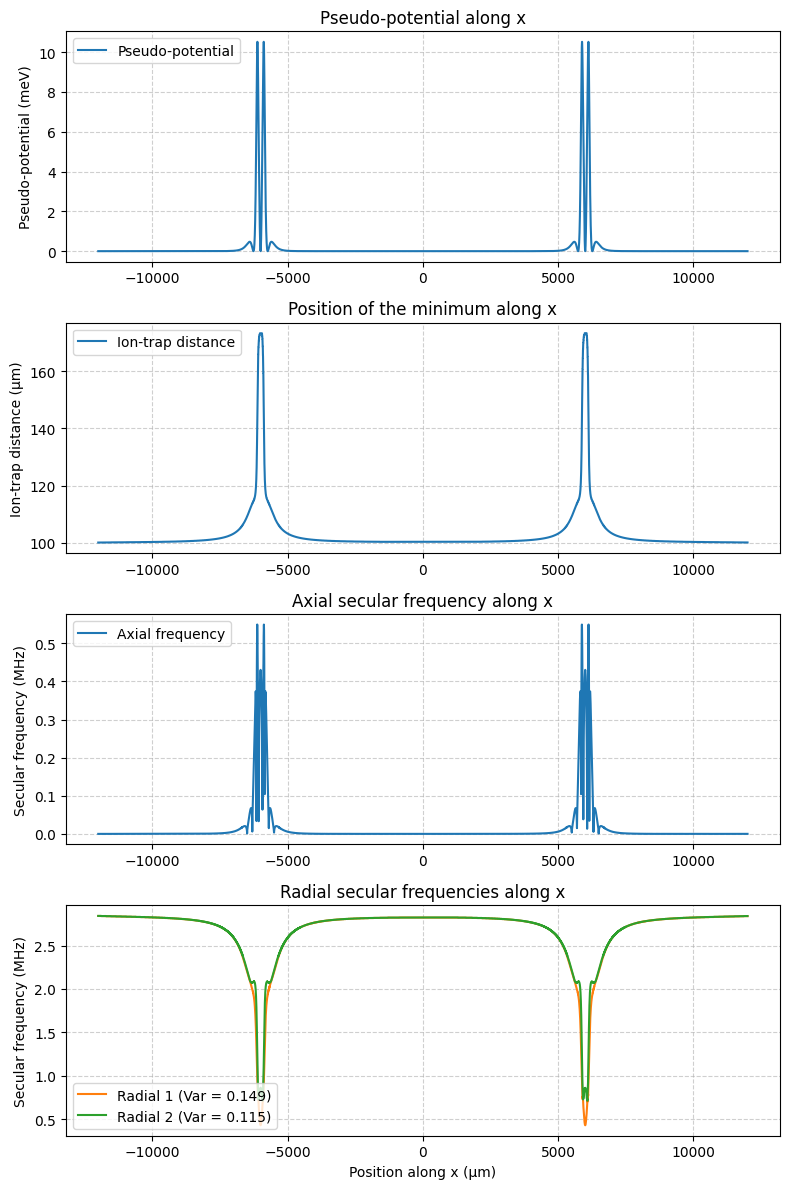

In [133]:
plot_ps(x_values, pseudopot_values_non_opt, positions_non_opt, omega_sec_values_non_opt)

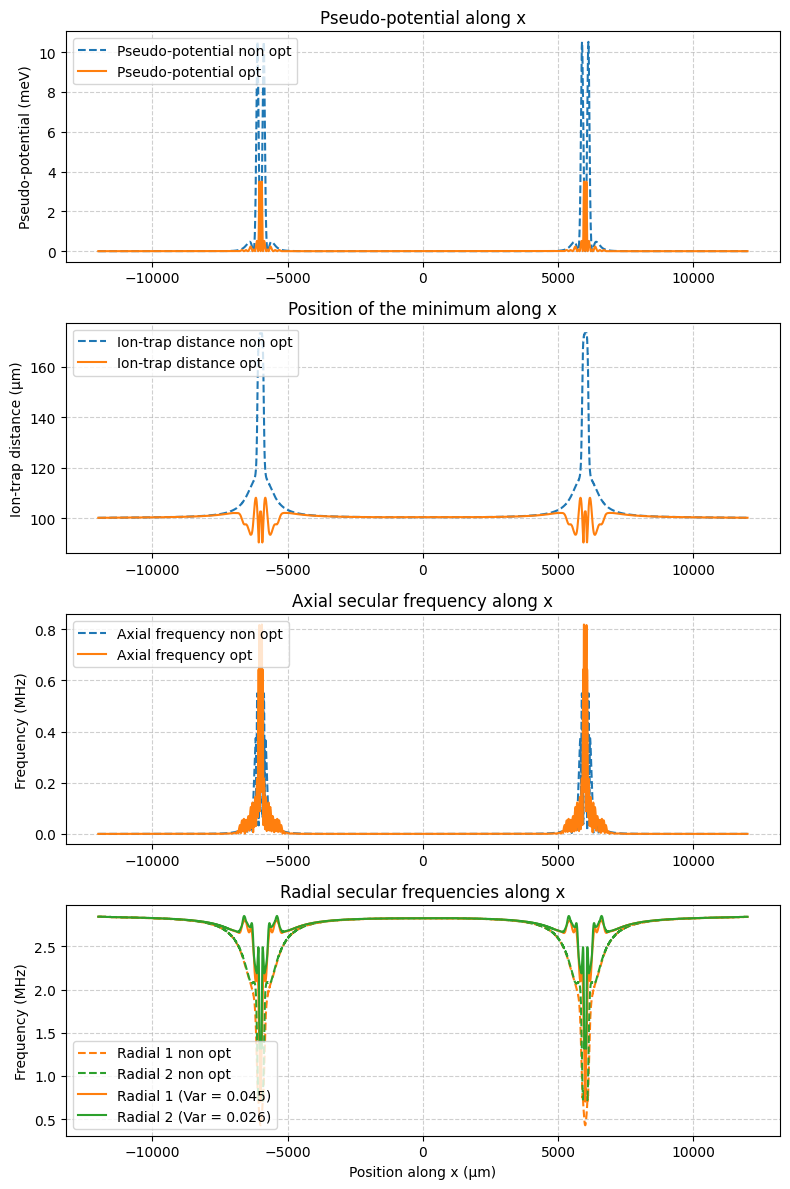

In [106]:
plot_joint_ps(x_values, non_opt_params, opt_params)